In [1]:
import os

os.environ["LD_LIBRARY_PATH"] = "usr/lib/wsl/lib"

In [2]:
!pip install memory-profiler

In [3]:
from karabo.imaging.imager import Imager
from karabo.simulation.telescope import Telescope
from karabo.simulation.observation import Observation
from karabo.simulation.interferometer import InterferometerSimulation
from karabo.simulation.sky_model import SkyModel
from karabo.sourcedetection.result import (
    PyBDSFSourceDetectionResult,
)
from karabo.sourcedetection.evaluation import SourceDetectionEvaluation
import numpy as np
from memory_profiler import memory_usage

# Render plots inline
%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


In [4]:
# Measure memory usage
def measure_memory(func, *args, **kwargs):
    mem_usage_before = memory_usage(max_usage=True)
    result = func(*args, **kwargs)
    mem_usage_after = memory_usage(max_usage=True)
    print(f"Memory usage: {mem_usage_after - mem_usage_before} MiB")
    return result

# Source Detection

## Simulation

In [5]:
# Get GLEAM Survey Sky
phase_center = [21.44213503, -30.70729488]
sky = measure_memory(SkyModel.get_BATTYE_sky)

Memory usage: 12.48828125 MiB


In [6]:
sky.sources

<xarray.DataArray 'array-2952e4333d3155fd647b9880ed02bcc6' (
                                                            source_name: 1119647576,
                                                            columns: 14)>
dask.array<setitem, shape=(1119647576, 14), dtype=float64, chunksize=(1198372, 14), chunktype=numpy.ndarray>
Dimensions without coordinates: source_name, columns

In [7]:
sky_filtered = measure_memory(
    sky.filter_by_radius_euclidean_flat_approximation,
    0,
    3,
    phase_center[0],
    phase_center[1],
)

Calculating distances
Calculating Mask
Filtering sources
Rechunking sky
Memory usage: 11726.97265625 MiB


In [8]:
sky_filtered.setup_default_wcs(phase_center=phase_center)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---AIR'  'DEC--AIR'  
CRVAL : 21.44213503  -30.70729488  
CRPIX : 0.0  0.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -1.0  1.0  
NAXIS : 0  0

In [9]:
sky_filtered.sources

<xarray.DataArray 'array-2952e4333d3155fd647b9880ed02bcc6' (
                                                            source_name: 2696470,
                                                            columns: 14)>
dask.array<rechunk-merge, shape=(2696470, 14), dtype=float64, chunksize=(1198372, 14), chunktype=numpy.ndarray>
Dimensions without coordinates: source_name, columns

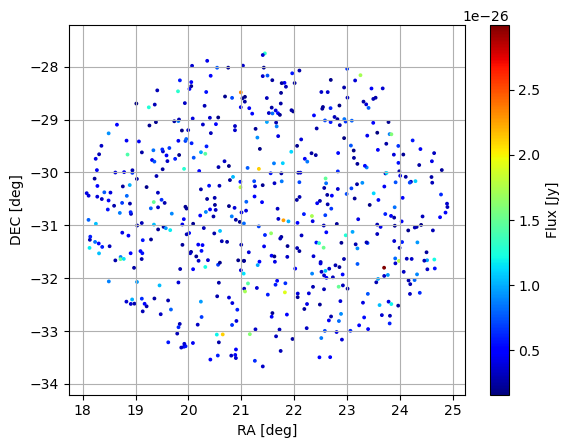

In [10]:
sky_filtered.explore_sky(
    phase_center,
    s=3,
    cmap="jet",
    cbar_label="Flux [Jy]",
    cfun=None,
    wcs_enabled=False,
    xlabel="RA [deg]",
    ylabel="DEC [deg]",
    idx_to_plot=np.arange(0, sky_filtered.sources.shape[0], 5000),
)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

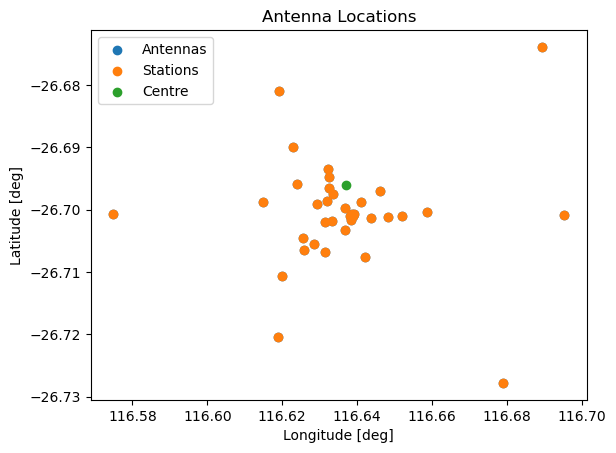

In [11]:
askap_tel = Telescope.get_ASKAP_Telescope()
askap_tel.plot_telescope()

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [12]:
# Give the workers more ram, if you are working locally
from karabo.util.dask import DaskHandler

DaskHandler.min_gb_ram_per_worker = 16

observation_settings = Observation(
    start_frequency_hz=100e6,
    phase_centre_ra_deg=phase_center[0],
    phase_centre_dec_deg=phase_center[1],
    number_of_channels=10,
    number_of_time_steps=24,
)

interferometer_sim = InterferometerSimulation(channel_bandwidth_hz=1e6, use_gpus=True)
visibility_askap = interferometer_sim.run_simulation(
    askap_tel, sky_filtered, observation_settings
)

Parameter 'use_dask' is None! Using function 'karabo.util.dask.DaskHandler.should_dask_be_used()' to overwrite parameter 'use_dask' to False.
Saved visibility to /home/vincenzo/Karabo-Pipeline/karabo/examples/karabo_folder/visibility


In [13]:
imaging_npixel = 2048
imaging_cellsize = 3.878509448876288e-05

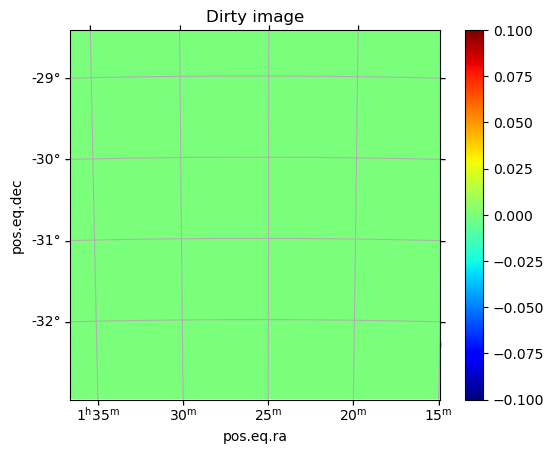

In [14]:
imager_askap = Imager(
    visibility_askap,
    imaging_npixel=imaging_npixel,
    imaging_cellsize=imaging_cellsize,
)
dirty = imager_askap.get_dirty_image()
dirty.plot(title="Dirty image")

In [15]:
beam_guess = PyBDSFSourceDetectionResult.guess_beam_parameters(
    imager=imager_askap, method="rascil_1_iter"
)
detection_result_dirty = PyBDSFSourceDetectionResult.detect_sources_in_image(
    image=dirty, beam=beam_guess
)

RuntimeError: Slicer error:infer: startResult>=shape

In [ ]:
fig, ax = plt.subplots(
    figsize=(7, 7),
)
sc = ax.scatter(ground_truth[0], ground_truth[1], s=20)

# for idx, i in enumerate(range(ground_truth[0].shape[0])):
#     ax.annotate(sky[idx,-1], (ground_truth[0][i], ground_truth[1][i]))

plt.axis("equal")
plt.title("ground-truth source positions on image")
plt.xlim((0, imaging_npixel))
plt.ylim((0, imaging_npixel))
plt.xlabel("pixel-count width")
plt.ylabel("pixel-count height")
plt.show()